In [25]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
 
from itertools import product
from tqdm import tqdm_notebook

import Model_Evaluation as me

In [2]:
#books = pd.read_csv('/Users/rahulnair/Desktop/Labelmaster_/Sales_Data/Books_ext_fs.csv')
#books = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LabelMaster/LabelMaster Data/Books_ext.csv')
#books = pd.read_csv('C:/Users/11602/OneDrive/Practicum/LabelMaster_Sales_Forecasting/data/Books_ext_fs.csv')
books = pd.read_csv('C:/Users/Sword Guo/OneDrive/Practicum/LabelMaster_Sales_Forecasting/data/Books_ext_fs.csv')
sales = books[['Year_Month','Sum of Sales']]
sales['Sum of Sales'] = sales['Sum of Sales']/100000
sales

,Year_Month,Sum of Sales
0,2008-01,2.826041
1,2008-02,2.624744
2,2008-03,3.260597
3,2008-04,2.153875
4,2008-05,4.995599
...,...,...
150,2020-07,1.503481
151,2020-08,1.560669
152,2020-09,4.687110
153,2020-10,11.184468


In [3]:
books = books.dropna(axis = 1)
exog = books.iloc[:,2:]
exog

,"FTR Truck Loadings (000s, SA)_freight_m_trucking","FTR Active Truck Utilization (%, SA)_freight_m_trucking","Reefer Trailer Loadings (000s, SA)_freight_m_trucking","Tank Trailer Loadings (000s, SA)_freight_m_trucking","Chemicals & Allied Products (000s, SA)_freight_m_trucking",Spot TL Rates (w/o FSC)_rates_m_trucking,Total LTL (w/o FSC)_rates_m_trucking,Total LTL (w/ FSC)_rates_m_trucking,Contract TL Tank Rates (w/o FSC)_rates_m_trucking,"OEM Net Orders (U.S. / CAN, units)_indicators_m_trucking",...,BUILD FOR_All_Other,Change in Distillate Fuel Inventories_x,Intermodal Revenue Movements (IANA-ETSO)_Total_x,FTR Intermodal Competitive Index_Intermodal Competitive Index (0=Neutral)_x,U.S. Origin Intermodal Volumes_International_x,Canada Origin Intermodal Volumes_Domestic_x,"N.A. Port Activity, Total TEUs_Exports_x","West Coast Port Activity, Total TEUs_Exports_x","Gulf Coast Port Activity, Total TEUs_Exports_x","Western Canadian Port Activity, Total TEUs_Exports_x"
0,57633.608984,88.294650,3940.638792,6915.782704,3013.868684,96.932289,99.755501,114.408275,99.995901,16185.0,...,969.0,-2981.0,1156094.0,3.341993,557011.0,46969.0,1.035742e+06,428531.270000,90322.590000,70230.000000
1,57175.659828,87.998407,3927.115595,6836.939472,2975.285847,99.719858,99.755501,114.867841,100.276486,11091.0,...,1104.0,-13327.0,1088826.0,2.285576,501961.0,44924.0,1.138045e+06,478707.330000,100410.660000,86567.000000
2,56814.700553,87.790155,3922.853376,6758.129439,2941.079313,103.347853,100.488998,117.070858,99.727612,14647.0,...,1158.0,-9852.0,1082825.0,1.924076,481100.0,46727.0,1.167742e+06,500866.450000,93384.280000,80451.000000
3,56916.813852,89.639867,3978.633479,6858.428982,2906.591249,111.718085,101.589242,122.811123,99.057287,14264.0,...,931.0,-733.0,1158286.0,5.986521,528843.0,53497.0,1.156788e+06,486063.840000,101642.940000,84739.000000
4,56194.246889,89.134818,3990.692209,6804.610846,2872.185063,117.525703,101.314181,123.968232,97.828232,12060.0,...,991.0,6890.0,1184144.0,7.940801,541259.0,53653.0,1.185090e+06,490618.980000,105424.640000,89548.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,61469.059874,89.962431,4379.187334,6571.127779,2639.040651,115.128696,102.231051,113.578198,115.191063,19213.0,...,1359.0,2134.0,1526490.0,-0.192121,513074.0,57503.0,1.095134e+06,393775.832112,125276.157772,103172.000000
151,62140.797176,90.641835,4404.415547,6601.260917,2676.666422,129.107598,104.339853,115.812566,114.911925,18302.0,...,1671.0,1353.0,1575928.0,0.625716,546740.0,56478.0,1.108304e+06,389408.103791,125319.157772,93979.000000
152,62170.174317,90.587889,4381.188114,6556.745680,2600.808117,136.100117,105.898533,117.464895,115.470202,28766.0,...,1711.0,-7196.0,1617044.0,5.475578,557748.0,59269.0,1.099329e+06,386298.700253,117576.128306,103129.000000
153,62870.759335,94.367218,4436.920215,6523.796564,2593.200335,140.122763,106.265281,117.793788,115.098017,36912.0,...,2018.0,-10130.4,1705714.0,9.817290,591616.0,60708.0,1.186353e+06,410614.677268,123604.184721,105255.000000


In [4]:
train,test = train_test_split(sales, test_size=0.075, random_state=60616, shuffle=False)

In [5]:
test

,Year_Month,Sum of Sales
143,2019-12,5.255255
144,2020-01,5.733124
145,2020-02,2.894873
146,2020-03,2.462465
147,2020-04,2.193816
148,2020-05,1.286718
149,2020-06,1.367123
150,2020-07,1.503481
151,2020-08,1.560669
152,2020-09,4.687110


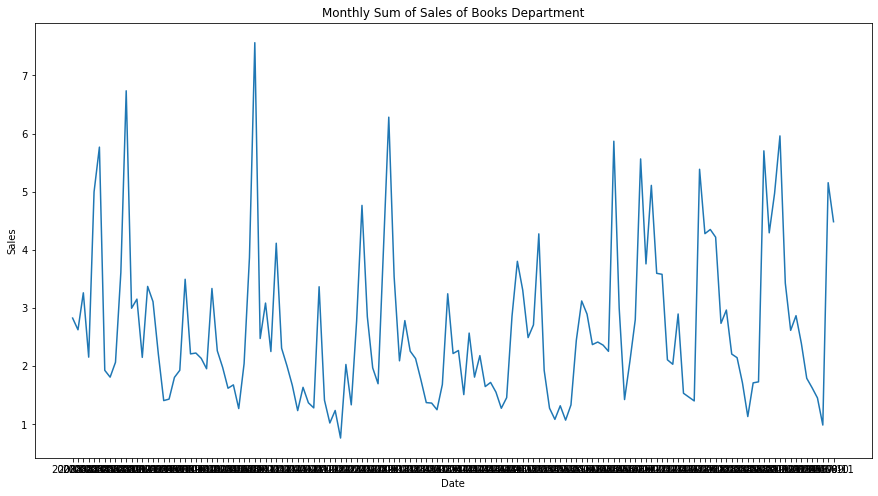

In [6]:
plt.figure(figsize=[15,8])
plt.plot(train['Year_Month'],train['Sum of Sales'])
plt.title('Monthly Sum of Sales of Books Department')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [8]:
ad_fuller_result = adfuller(train['Sum of Sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.448654278403226
p-value: 5.74799439008589e-11


Since the p-value is greater than 0.5, we cannot reject null hypothesis and must assume that the series is not stationary.

sales['sales_diffed'] = sales['Sum of Sales'].diff(1)
sales

ad_fuller_result = adfuller(sales['sales_diffed'][1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

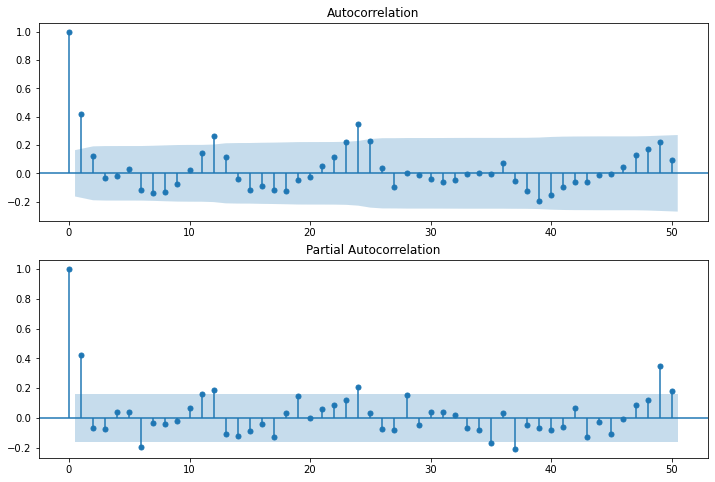

In [9]:
fig, ax = plt.subplots(2,1, figsize= (12,8))
fig = sm.graphics.tsa.plot_acf(train['Sum of Sales'], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train['Sum of Sales'], lags=50, ax=ax[1])
plt.show()

# New Section

In [37]:
p = [0,1,2]
d = [0,1]
q = [0,1,2]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

df = pd.DataFrame()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['Sum of Sales'],
                                            order=param,
                                            seasonal_order=param_seasonal)
            results = mod.fit()
            print('ARIMA{}x{}- AIC:{}'.format(param, param_seasonal, results.aic))

            combo = [(param,param_seasonal,results.aic)]
            df = df.append(combo)
            print(" ")
        except:
            continue
df.columns = ['param','param_seasonal', 'AIC']

ARIMA(0, 0, 0)x(0, 0, 0, 12)- AIC:717.5785292318133
 
ARIMA(0, 0, 0)x(0, 0, 1, 12)- AIC:653.5776806010631
 
ARIMA(0, 0, 0)x(0, 0, 2, 12)- AIC:594.7474520582172
 
ARIMA(0, 0, 0)x(0, 1, 0, 12)- AIC:483.85129419470815
 
ARIMA(0, 0, 0)x(0, 1, 1, 12)- AIC:436.14502889472817
 
ARIMA(0, 0, 0)x(0, 1, 2, 12)- AIC:436.78898095311376
 
ARIMA(0, 0, 0)x(1, 0, 0, 12)- AIC:542.1055882327469
 
ARIMA(0, 0, 0)x(1, 0, 1, 12)- AIC:497.68370639845443
 
ARIMA(0, 0, 0)x(1, 0, 2, 12)- AIC:499.1656035437626
 
ARIMA(0, 0, 0)x(1, 1, 0, 12)- AIC:436.3344741240974
 
ARIMA(0, 0, 0)x(1, 1, 1, 12)- AIC:435.2465681975523
 
ARIMA(0, 0, 0)x(1, 1, 2, 12)- AIC:429.5697942965095
 
ARIMA(0, 0, 0)x(2, 0, 0, 12)- AIC:498.6383187708254
 
ARIMA(0, 0, 0)x(2, 0, 1, 12)- AIC:497.8286391263845
 
ARIMA(0, 0, 0)x(2, 0, 2, 12)- AIC:491.70787967870655
 
ARIMA(0, 0, 0)x(2, 1, 0, 12)- AIC:437.0785958961045
 
ARIMA(0, 0, 0)x(2, 1, 1, 12)- AIC:432.5010912350658
 
ARIMA(0, 0, 0)x(2, 1, 2, 12)- AIC:430.55938602455467
 
ARIMA(0, 0, 1)x(0, 0, 

D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 2, 12)- AIC:420.05171895996966
 
ARIMA(0, 0, 1)x(2, 0, 0, 12)- AIC:483.01528713798797
 
ARIMA(0, 0, 1)x(2, 0, 1, 12)- AIC:477.58738974798075
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 0, 2, 12)- AIC:475.7406600614531
 
ARIMA(0, 0, 1)x(2, 1, 0, 12)- AIC:424.6037038708283
 
ARIMA(0, 0, 1)x(2, 1, 1, 12)- AIC:422.0709784927584
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 1, 2, 12)- AIC:421.9818232924008
 
ARIMA(0, 0, 2)x(0, 0, 0, 12)- AIC:567.6583567927687
 
ARIMA(0, 0, 2)x(0, 0, 1, 12)- AIC:538.6911657733332
 
ARIMA(0, 0, 2)x(0, 0, 2, 12)- AIC:524.0138053672893
 
ARIMA(0, 0, 2)x(0, 1, 0, 12)- AIC:464.29211975926717
 
ARIMA(0, 0, 2)x(0, 1, 1, 12)- AIC:420.63543302850775
 
ARIMA(0, 0, 2)x(0, 1, 2, 12)- AIC:422.00968685486396
 
ARIMA(0, 0, 2)x(1, 0, 0, 12)- AIC:504.0033348417413
 
ARIMA(0, 0, 2)x(1, 0, 1, 12)- AIC:472.039685167597
 
ARIMA(0, 0, 2)x(1, 0, 2, 12)- AIC:473.8699639532915
 
ARIMA(0, 0, 2)x(1, 1, 0, 12)- AIC:427.74294564818814
 
ARIMA(0, 0, 2)x(1, 1, 1, 12)- AIC:421.76322235978387
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 1, 2, 12)- AIC:420.7641402395671
 
ARIMA(0, 0, 2)x(2, 0, 0, 12)- AIC:479.3291297331146
 
ARIMA(0, 0, 2)x(2, 0, 1, 12)- AIC:473.7677759546869
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 2, 12)- AIC:473.5408251239702
 
ARIMA(0, 0, 2)x(2, 1, 0, 12)- AIC:424.01427843109866
 
ARIMA(0, 0, 2)x(2, 1, 1, 12)- AIC:422.1076238023777
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 1, 2, 12)- AIC:422.7276238606089
 
ARIMA(0, 1, 0)x(0, 0, 0, 12)- AIC:505.7616796325268
 
ARIMA(0, 1, 0)x(0, 0, 1, 12)- AIC:500.5105559352253
 
ARIMA(0, 1, 0)x(0, 0, 2, 12)- AIC:497.53791065560114
 
ARIMA(0, 1, 0)x(0, 1, 0, 12)- AIC:504.0708043672463
 
ARIMA(0, 1, 0)x(0, 1, 1, 12)- AIC:462.5096699225677
 
ARIMA(0, 1, 0)x(0, 1, 2, 12)- AIC:464.34809755652304
 
ARIMA(0, 1, 0)x(1, 0, 0, 12)- AIC:497.55136030962285
 
ARIMA(0, 1, 0)x(1, 0, 1, 12)- AIC:492.6042876815832
 
ARIMA(0, 1, 0)x(1, 0, 2, 12)- AIC:493.9941980071842
 
ARIMA(0, 1, 0)x(1, 1, 0, 12)- AIC:476.2807562135323
 
ARIMA(0, 1, 0)x(1, 1, 1, 12)- AIC:464.3608388864084
 
ARIMA(0, 1, 0)x(1, 1, 2, 12)- AIC:466.5096557239042
 
ARIMA(0, 1, 0)x(2, 0, 0, 12)- AIC:494.15986869862263
 
ARIMA(0, 1, 0)x(2, 0, 1, 12)- AIC:494.21115086313716
 
ARIMA(0, 1, 0)x(2, 0, 2, 12)- AIC:495.40577593022726
 
ARIMA(0, 1, 0)x(2, 1, 0, 12)- AIC:463.0025483809785
 
ARIMA(0, 1, 0)x(2, 1, 1, 12)- AIC:464.98727167200195
 
ARIMA(0, 1, 0)x(2, 1,

D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 2, 12)- AIC:427.04775442920345
 
ARIMA(0, 1, 1)x(2, 0, 0, 12)- AIC:462.24985292034694
 
ARIMA(0, 1, 1)x(2, 0, 1, 12)- AIC:464.0831748262707
 
ARIMA(0, 1, 1)x(2, 0, 2, 12)- AIC:459.0837312679448
 
ARIMA(0, 1, 1)x(2, 1, 0, 12)- AIC:435.258850053544
 
ARIMA(0, 1, 1)x(2, 1, 1, 12)- AIC:431.396694405041
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 2, 12)- AIC:428.85992645816447
 
ARIMA(0, 1, 2)x(0, 0, 0, 12)- AIC:469.51004414172553
 
ARIMA(0, 1, 2)x(0, 0, 1, 12)- AIC:465.251593696859
 
ARIMA(0, 1, 2)x(0, 0, 2, 12)- AIC:455.0456788844824
 
ARIMA(0, 1, 2)x(0, 1, 0, 12)- AIC:473.58904593840526
 
ARIMA(0, 1, 2)x(0, 1, 1, 12)- AIC:424.03085349272715
 
ARIMA(0, 1, 2)x(0, 1, 2, 12)- AIC:424.68736299086254
 
ARIMA(0, 1, 2)x(1, 0, 0, 12)- AIC:460.94251248960285
 
ARIMA(0, 1, 2)x(1, 0, 1, 12)- AIC:451.52719083332147
 
ARIMA(0, 1, 2)x(1, 0, 2, 12)- AIC:451.79282776269343
 
ARIMA(0, 1, 2)x(1, 1, 0, 12)- AIC:431.0950922452011
 
ARIMA(0, 1, 2)x(1, 1, 1, 12)- AIC:424.34153569842084
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 2, 12)- AIC:422.0893373542273
 
ARIMA(0, 1, 2)x(2, 0, 0, 12)- AIC:450.0430509400805
 
ARIMA(0, 1, 2)x(2, 0, 1, 12)- AIC:451.4474589608335
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 2, 12)- AIC:450.45890264803614
 
ARIMA(0, 1, 2)x(2, 1, 0, 12)- AIC:427.66476399486976
 
ARIMA(0, 1, 2)x(2, 1, 1, 12)- AIC:425.5790961593576
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 2, 12)- AIC:424.0882628068333
 
ARIMA(1, 0, 0)x(0, 0, 0, 12)- AIC:504.8053001961491
 
ARIMA(1, 0, 0)x(0, 0, 1, 12)- AIC:496.5800387279045
 
ARIMA(1, 0, 0)x(0, 0, 2, 12)- AIC:491.26412103998473
 
ARIMA(1, 0, 0)x(0, 1, 0, 12)- AIC:462.74280197584267
 
ARIMA(1, 0, 0)x(0, 1, 1, 12)- AIC:418.2553062018658
 
ARIMA(1, 0, 0)x(0, 1, 2, 12)- AIC:419.6853297910477
 
ARIMA(1, 0, 0)x(1, 0, 0, 12)- AIC:489.8059545759265
 
ARIMA(1, 0, 0)x(1, 0, 1, 12)- AIC:467.4400937073551
 
ARIMA(1, 0, 0)x(1, 0, 2, 12)- AIC:469.32884947507483
 
ARIMA(1, 0, 0)x(1, 1, 0, 12)- AIC:425.8655539575899
 
ARIMA(1, 0, 0)x(1, 1, 1, 12)- AIC:419.47741609314147
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 2, 12)- AIC:418.5693150117754
 
ARIMA(1, 0, 0)x(2, 0, 0, 12)- AIC:475.52851972338897
 
ARIMA(1, 0, 0)x(2, 0, 1, 12)- AIC:469.28000177412116
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 0, 2, 12)- AIC:469.6361751130219
 
ARIMA(1, 0, 0)x(2, 1, 0, 12)- AIC:421.8167277940367
 
ARIMA(1, 0, 0)x(2, 1, 1, 12)- AIC:419.9693871744744
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 1, 2, 12)- AIC:420.5269721381219
 
ARIMA(1, 0, 1)x(0, 0, 0, 12)- AIC:496.0231421660674
 
ARIMA(1, 0, 1)x(0, 0, 1, 12)- AIC:486.66778787846476
 
ARIMA(1, 0, 1)x(0, 0, 2, 12)- AIC:476.6547934396965
 
ARIMA(1, 0, 1)x(0, 1, 0, 12)- AIC:463.61489086761134
 
ARIMA(1, 0, 1)x(0, 1, 1, 12)- AIC:419.947632035003
 
ARIMA(1, 0, 1)x(0, 1, 2, 12)- AIC:421.48786337180906
 
ARIMA(1, 0, 1)x(1, 0, 0, 12)- AIC:478.7329989330153
 
ARIMA(1, 0, 1)x(1, 0, 1, 12)- AIC:463.84281760826167
 
ARIMA(1, 0, 1)x(1, 0, 2, 12)- AIC:465.8179258532475
 
ARIMA(1, 0, 1)x(1, 1, 0, 12)- AIC:427.75297131849163
 
ARIMA(1, 0, 1)x(1, 1, 1, 12)- AIC:421.30418881830724
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 2, 12)- AIC:420.485734482053
 
ARIMA(1, 0, 1)x(2, 0, 0, 12)- AIC:467.4310870547803
 
ARIMA(1, 0, 1)x(2, 0, 1, 12)- AIC:465.79565081741424
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 12)- AIC:465.1348588742417
 
ARIMA(1, 0, 1)x(2, 1, 0, 12)- AIC:423.7387093085435
 
ARIMA(1, 0, 1)x(2, 1, 1, 12)- AIC:421.7235291168645
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 2, 12)- AIC:422.4328619941309
 
ARIMA(1, 0, 2)x(0, 0, 0, 12)- AIC:476.3836757100189
 
ARIMA(1, 0, 2)x(0, 0, 1, 12)- AIC:472.07909528225315
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 2)x(0, 0, 2, 12)- AIC:461.85850421595524
 
ARIMA(1, 0, 2)x(0, 1, 0, 12)- AIC:465.3651318937396
 
ARIMA(1, 0, 2)x(0, 1, 1, 12)- AIC:421.2210471890477
 
ARIMA(1, 0, 2)x(0, 1, 2, 12)- AIC:422.75483290782506
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 0, 12)- AIC:467.7569737698046
 
ARIMA(1, 0, 2)x(1, 0, 1, 12)- AIC:458.60761193342904
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 12)- AIC:458.658294037381
 
ARIMA(1, 0, 2)x(1, 1, 0, 12)- AIC:429.48453482237886
 
ARIMA(1, 0, 2)x(1, 1, 1, 12)- AIC:422.59312554183697
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 2, 12)- AIC:421.6542114905237
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 12)- AIC:456.90800177218375
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 12)- AIC:458.43705309482897
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 2, 12)- AIC:457.15748461455456
 
ARIMA(1, 0, 2)x(2, 1, 0, 12)- AIC:425.2556015358076
 
ARIMA(1, 0, 2)x(2, 1, 1, 12)- AIC:423.29924802186395
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 2, 12)- AIC:423.59503160993813
 
ARIMA(1, 1, 0)x(0, 0, 0, 12)- AIC:498.6687218665876
 
ARIMA(1, 1, 0)x(0, 0, 1, 12)- AIC:491.59141359377804
 
ARIMA(1, 1, 0)x(0, 0, 2, 12)- AIC:486.090588992466
 
ARIMA(1, 1, 0)x(0, 1, 0, 12)- AIC:488.3740718167721
 
ARIMA(1, 1, 0)x(0, 1, 1, 12)- AIC:448.5177037423447
 
ARIMA(1, 1, 0)x(0, 1, 2, 12)- AIC:450.476839935725
 
ARIMA(1, 1, 0)x(1, 0, 0, 12)- AIC:486.81730022982947
 
ARIMA(1, 1, 0)x(1, 0, 1, 12)- AIC:479.839892326826
 
ARIMA(1, 1, 0)x(1, 0, 2, 12)- AIC:481.5157554122359
 
ARIMA(1, 1, 0)x(1, 1, 0, 12)- AIC:459.9534232334188
 
ARIMA(1, 1, 0)x(1, 1, 1, 12)- AIC:450.46913834343025
 
ARIMA(1, 1, 0)x(1, 1, 2, 12)- AIC:452.4456589604467
 
ARIMA(1, 1, 0)x(2, 0, 0, 12)- AIC:481.20077653853343
 
ARIMA(1, 1, 0)x(2, 0, 1, 12)- AIC:481.5308938820632
 
ARIMA(1, 1, 0)x(2, 0, 2, 12)- AIC:483.51549576407945
 
ARIMA(1, 1, 0)x(2, 1, 0, 12)- AIC:452.3934775230261
 
ARIMA(1, 1, 0)x(2, 1, 1, 12)- AIC:451.969325943799
 
ARIMA(1, 1, 0)x(2, 1, 2, 1

D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 2, 12)- AIC:421.8243094544679
 
ARIMA(1, 1, 1)x(2, 0, 0, 12)- AIC:447.4087739835388
 
ARIMA(1, 1, 1)x(2, 0, 1, 12)- AIC:448.4733759545618
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 2, 12)- AIC:448.5541408152455
 
ARIMA(1, 1, 1)x(2, 1, 0, 12)- AIC:425.9120410711123
 
ARIMA(1, 1, 1)x(2, 1, 1, 12)- AIC:424.58510280104156
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 2, 12)- AIC:423.82795341077144
 
ARIMA(1, 1, 2)x(0, 0, 0, 12)- AIC:468.12157447798813
 
ARIMA(1, 1, 2)x(0, 0, 1, 12)- AIC:462.85618931051897
 
ARIMA(1, 1, 2)x(0, 0, 2, 12)- AIC:454.30205262740515
 
ARIMA(1, 1, 2)x(0, 1, 0, 12)- AIC:466.6567313918141
 
ARIMA(1, 1, 2)x(0, 1, 1, 12)- AIC:424.34048299188214
 
ARIMA(1, 1, 2)x(0, 1, 2, 12)- AIC:425.43496571242804
 
ARIMA(1, 1, 2)x(1, 0, 0, 12)- AIC:458.3296366886723
 
ARIMA(1, 1, 2)x(1, 0, 1, 12)- AIC:449.87140262678724
 
ARIMA(1, 1, 2)x(1, 0, 2, 12)- AIC:450.47252739863353
 
ARIMA(1, 1, 2)x(1, 1, 0, 12)- AIC:431.9504384168483
 
ARIMA(1, 1, 2)x(1, 1, 1, 12)- AIC:425.215485634938
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 2, 12)- AIC:423.79080300016153
 
ARIMA(1, 1, 2)x(2, 0, 0, 12)- AIC:449.3710499917725
 
ARIMA(1, 1, 2)x(2, 0, 1, 12)- AIC:450.4268072219062
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 2, 12)- AIC:450.53480481668237
 
ARIMA(1, 1, 2)x(2, 1, 0, 12)- AIC:427.90099295688066
 
ARIMA(1, 1, 2)x(2, 1, 1, 12)- AIC:426.5678539186673
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 2, 12)- AIC:425.8188599464313
 
ARIMA(2, 0, 0)x(0, 0, 0, 12)- AIC:500.9311715958812
 
ARIMA(2, 0, 0)x(0, 0, 1, 12)- AIC:492.0772931616976
 
ARIMA(2, 0, 0)x(0, 0, 2, 12)- AIC:485.13464273542087
 
ARIMA(2, 0, 0)x(0, 1, 0, 12)- AIC:463.7991444876367
 
ARIMA(2, 0, 0)x(0, 1, 1, 12)- AIC:420.0366936570847
 
ARIMA(2, 0, 0)x(0, 1, 2, 12)- AIC:421.54191003976393
 
ARIMA(2, 0, 0)x(1, 0, 0, 12)- AIC:484.7399841484097
 
ARIMA(2, 0, 0)x(1, 0, 1, 12)- AIC:467.35032495327675
 
ARIMA(2, 0, 0)x(1, 0, 2, 12)- AIC:469.3143616921403
 
ARIMA(2, 0, 0)x(1, 1, 0, 12)- AIC:427.7613777370118
 
ARIMA(2, 0, 0)x(1, 1, 1, 12)- AIC:421.34958447650297
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 1, 2, 12)- AIC:420.50879389530326
 
ARIMA(2, 0, 0)x(2, 0, 0, 12)- AIC:473.8488357917553
 
ARIMA(2, 0, 0)x(2, 0, 1, 12)- AIC:469.29385381355223
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 0, 2, 12)- AIC:469.8849267953608
 
ARIMA(2, 0, 0)x(2, 1, 0, 12)- AIC:423.7518345334676
 
ARIMA(2, 0, 0)x(2, 1, 1, 12)- AIC:421.77538758295964
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 1, 2, 12)- AIC:422.46309309521627
 
ARIMA(2, 0, 1)x(0, 0, 0, 12)- AIC:473.2096229269247
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 1)x(0, 0, 1, 12)- AIC:467.70192504265935
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 1)x(0, 0, 2, 12)- AIC:459.12723966446447
 
ARIMA(2, 0, 1)x(0, 1, 0, 12)- AIC:465.3548047146378
 
ARIMA(2, 0, 1)x(0, 1, 1, 12)- AIC:421.36823095201936
 
ARIMA(2, 0, 1)x(0, 1, 2, 12)- AIC:422.9167744539592
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 0, 12)- AIC:463.1623903286641
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 12)- AIC:454.8505710940525
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 12)- AIC:455.42499642791995
 
ARIMA(2, 0, 1)x(1, 1, 0, 12)- AIC:429.49713125651243
 
ARIMA(2, 0, 1)x(1, 1, 1, 12)- AIC:422.7498328253107
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 2, 12)- AIC:421.72154922141465
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12)- AIC:454.2618302465132
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12)- AIC:455.7566122896392
 
ARIMA(2, 0, 1)x(2, 0, 2, 12)- AIC:456.05334568684475
 
ARIMA(2, 0, 1)x(2, 1, 0, 12)- AIC:425.37537996163235
 
ARIMA(2, 0, 1)x(2, 1, 1, 12)- AIC:423.36054469227236
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 1, 2, 12)- AIC:423.71086533583934
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 0, 0, 12)- AIC:474.9082413366155
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 0, 1, 12)- AIC:469.66428417745635
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 0, 2, 12)- AIC:461.1587172301547
 
ARIMA(2, 0, 2)x(0, 1, 0, 12)- AIC:467.3481728119708
 
ARIMA(2, 0, 2)x(0, 1, 1, 12)- AIC:423.2202360290115
 
ARIMA(2, 0, 2)x(0, 1, 2, 12)- AIC:424.56858866707273
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 0, 12)- AIC:465.1646626806503
 
ARIMA(2, 0, 2)x(1, 0, 1, 12)- AIC:457.2101810776346
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 12)- AIC:457.618229825703
 
ARIMA(2, 0, 2)x(1, 1, 0, 12)- AIC:429.7848040463223
 
ARIMA(2, 0, 2)x(1, 1, 1, 12)- AIC:424.86034664872614
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 2, 12)- AIC:423.6553534014249
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 12)- AIC:456.26506805463157
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12)- AIC:458.3647263352733
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 2, 12)- AIC:458.3457714210711
 
ARIMA(2, 0, 2)x(2, 1, 0, 12)- AIC:426.29557960268653
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 1, 12)- AIC:425.2685987620782
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 2, 12)- AIC:425.5957679960079
 
ARIMA(2, 1, 0)x(0, 0, 0, 12)- AIC:496.22218508693044
 
ARIMA(2, 1, 0)x(0, 0, 1, 12)- AIC:488.82735530628884
 
ARIMA(2, 1, 0)x(0, 0, 2, 12)- AIC:482.603389052536
 
ARIMA(2, 1, 0)x(0, 1, 0, 12)- AIC:484.52234564117265
 
ARIMA(2, 1, 0)x(0, 1, 1, 12)- AIC:441.9900285425374
 
ARIMA(2, 1, 0)x(0, 1, 2, 12)- AIC:443.8688770988947
 
ARIMA(2, 1, 0)x(1, 0, 0, 12)- AIC:483.53393448242514
 
ARIMA(2, 1, 0)x(1, 0, 1, 12)- AIC:474.4072726783238
 
ARIMA(2, 1, 0)x(1, 0, 2, 12)- AIC:476.2885480341076
 
ARIMA(2, 1, 0)x(1, 1, 0, 12)- AIC:453.881840878279
 
ARIMA(2, 1, 0)x(1, 1, 1, 12)- AIC:443.84906869833264
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 1, 2, 12)- AIC:444.23001939296614
 
ARIMA(2, 1, 0)x(2, 0, 0, 12)- AIC:476.6388060132408
 
ARIMA(2, 1, 0)x(2, 0, 1, 12)- AIC:476.2425425688755
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 2, 12)- AIC:476.8282551048362
 
ARIMA(2, 1, 0)x(2, 1, 0, 12)- AIC:446.4780562066442
 
ARIMA(2, 1, 0)x(2, 1, 1, 12)- AIC:445.45392078399465
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 2, 12)- AIC:446.1300447773538
 
ARIMA(2, 1, 1)x(0, 0, 0, 12)- AIC:468.0091837905966
 
ARIMA(2, 1, 1)x(0, 0, 1, 12)- AIC:462.84570223938374
 
ARIMA(2, 1, 1)x(0, 0, 2, 12)- AIC:454.3002348655205
 
ARIMA(2, 1, 1)x(0, 1, 0, 12)- AIC:466.957114124349
 
ARIMA(2, 1, 1)x(0, 1, 1, 12)- AIC:424.35044001692813
 
ARIMA(2, 1, 1)x(0, 1, 2, 12)- AIC:425.435516429372
 
ARIMA(2, 1, 1)x(1, 0, 0, 12)- AIC:458.32881936316574
 
ARIMA(2, 1, 1)x(1, 0, 1, 12)- AIC:449.87574990557385
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 0, 2, 12)- AIC:450.4716012110611
 
ARIMA(2, 1, 1)x(1, 1, 0, 12)- AIC:431.95052344883413
 
ARIMA(2, 1, 1)x(1, 1, 1, 12)- AIC:425.21568034095446
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 2, 12)- AIC:423.7960150820003
 
ARIMA(2, 1, 1)x(2, 0, 0, 12)- AIC:449.36900826374836
 
ARIMA(2, 1, 1)x(2, 0, 1, 12)- AIC:450.42585021557863
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 2, 12)- AIC:450.53778190866535
 
ARIMA(2, 1, 1)x(2, 1, 0, 12)- AIC:427.9019675797461
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 12)- AIC:426.63357174400153
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 2, 12)- AIC:425.9050798718822
 
ARIMA(2, 1, 2)x(0, 0, 0, 12)- AIC:470.3243699685228
 
ARIMA(2, 1, 2)x(0, 0, 1, 12)- AIC:464.7899917026043
 
ARIMA(2, 1, 2)x(0, 0, 2, 12)- AIC:455.9188238334142
 
ARIMA(2, 1, 2)x(0, 1, 0, 12)- AIC:468.3224544005994
 
ARIMA(2, 1, 2)x(0, 1, 1, 12)- AIC:426.0649207492197
 
ARIMA(2, 1, 2)x(0, 1, 2, 12)- AIC:427.44008657451263
 
ARIMA(2, 1, 2)x(1, 0, 0, 12)- AIC:460.0552143833521
 
ARIMA(2, 1, 2)x(1, 0, 1, 12)- AIC:451.6047308519396
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 2, 12)- AIC:451.7240773771665
 
ARIMA(2, 1, 2)x(1, 1, 0, 12)- AIC:433.93984834940454
 
ARIMA(2, 1, 2)x(1, 1, 1, 12)- AIC:426.69564691514086
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 2, 12)- AIC:425.2995118133425
 
ARIMA(2, 1, 2)x(2, 0, 0, 12)- AIC:450.6329516987614
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 12)- AIC:451.7845256315722
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 2, 12)- AIC:451.84197262572417
 
ARIMA(2, 1, 2)x(2, 1, 0, 12)- AIC:428.85569575579336
 
ARIMA(2, 1, 2)x(2, 1, 1, 12)- AIC:428.5687964810474
 
ARIMA(2, 1, 2)x(2, 1, 2, 12)- AIC:427.8055512146475
 


D:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [38]:
df = df.sort_values('AIC').reset_index(drop= True)
df

,param,param_seasonal,AIC
0,"(1, 0, 0)","(0, 1, 1, 12)",418.255306
1,"(1, 0, 0)","(1, 1, 2, 12)",418.569315
2,"(1, 0, 0)","(1, 1, 1, 12)",419.477416
3,"(1, 0, 0)","(0, 1, 2, 12)",419.685330
4,"(1, 0, 1)","(0, 1, 1, 12)",419.947632
...,...,...,...
319,"(0, 0, 1)","(0, 0, 1, 12)",575.798438
320,"(0, 0, 0)","(0, 0, 2, 12)",594.747452
321,"(0, 0, 1)","(0, 0, 0, 12)",616.540654
322,"(0, 0, 0)","(0, 0, 1, 12)",653.577681


The above output suggests that SARIMAX(3,0,0)(3,0,0,12) yields the lowest AIC value of 328.424883. Therefore we should consider this to be the optimal option.

In [39]:
mod = sm.tsa.statespace.SARIMAX(train['Sum of Sales'],
                                order=(1, 0, 0),
                                seasonal_order=(0, 1, 1, 12))
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         Sum of Sales   No. Observations:                  143
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -206.128
Date:                              Mon, 29 Mar 2021   AIC                            418.255
Time:                                      21:48:01   BIC                            426.881
Sample:                                           0   HQIC                           421.760
                                              - 143                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3740      0.100      3.743      0.000       0.178       0.570
ma.S.L12      -0.69

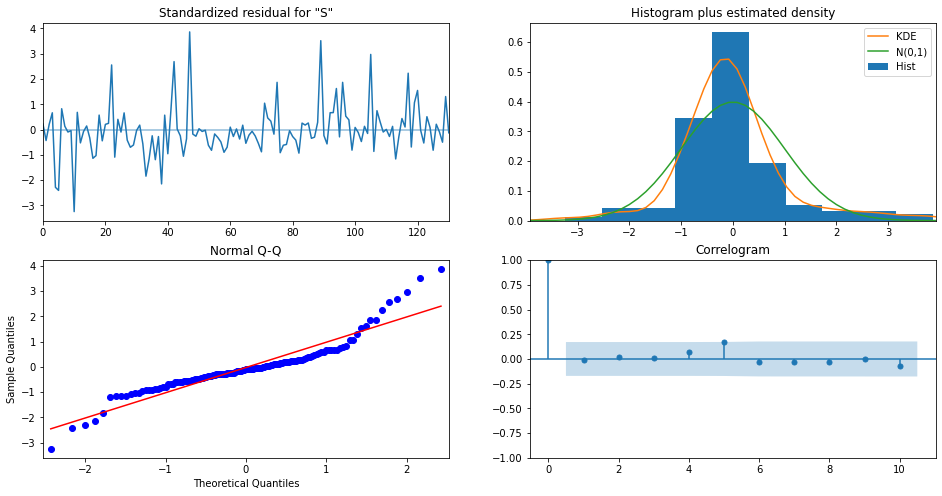

In [40]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Here we will forecast the values using the model. Can change starting point from which we need to forecast. For now we will keep starting point after 50 observations

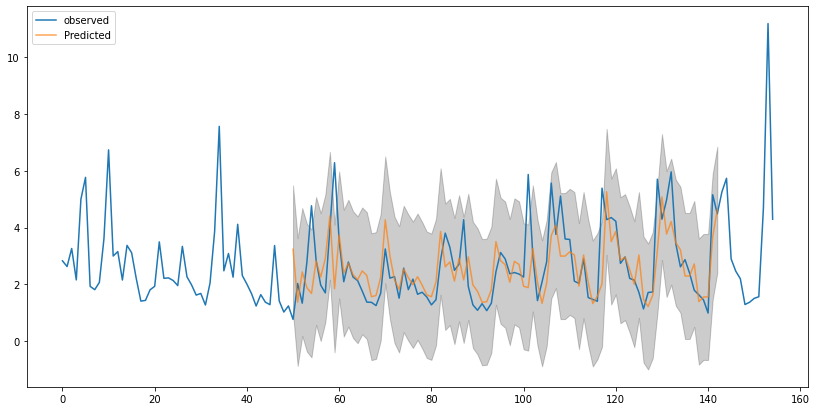

In [41]:
#Point from which prediction starts
start_point = 50
pred = results.get_prediction(start=start_point)
pred_ci = pred.conf_int()
ax = sales['Sum of Sales'].plot(label='observed',)
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

In [42]:
results.forecast(steps=12)

143    4.211353
144    4.460591
145    2.892006
146    2.831927
147    2.549591
148    2.203163
149    2.362365
150    1.676370
151    1.541110
152    1.411440
153    4.289562
154    4.260866
Name: predicted_mean, dtype: float64

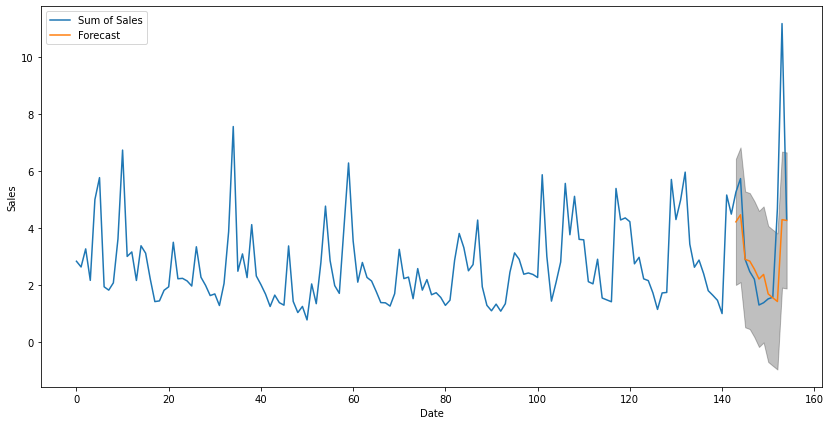

In [43]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = sales.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

# Model Evaluation
 - Mean Absolute Percentage Error
 - Mean Absolute Error
 - BIAS
 - Mean Squared Error
 - Root Mean Squared Error

In [51]:
predictions = pred.predicted_mean
actual = train['Sum of Sales'][start_point:]
me.evaluate_model(predictions,actual)

			Model Performance

Mean Absolute Percentage Error: 0.28916459474126316

Mean Absolute Error: 0.7252759117542666

BIAS: 0.10750783041400364

Mean Squared Error: 1.0748878248303333

Root Mean Squared Error: 1.0367679705847077


In [52]:
test_prediction = results.forecast(steps=12)
test_actual = test['Sum of Sales']
me.evaluate_model(test_prediction,test_actual)

			Model Performance

Mean Absolute Percentage Error: 0.30200513177524907

Mean Absolute Error: 1.2791712283671546

BIAS: 0.8108686585978901

Mean Squared Error: 7.890095777956101

Root Mean Squared Error: 2.8089314299135357
